In [76]:
from thejoker.data import RVData
from thejoker.plot import plot_rv_curves
from thejoker.sampler import compute_likelihoods
import astropy.units as u
import schwimmbad
from astropy.io import fits
from astropy.table import Table

from astropy.constants import G, sigma_sb

import os

import numpy as np
import matplotlib.pyplot as plt

iso = Table(fits.getdata('/home/cody/Binary Search/parsec_decamsdss_all.fits.gz',1))
AllAvgSimp = Table(fits.getdata('/home/cody/Binary Search/AllAvgSimp.fits',1))
AllVisSimp   = Table(fits.getdata('/home/cody/Binary Search/AllVisSimp.fits',1))

In [ ]:
def ln_likelihoods(samples)
    #Loop through all the different good samples that survive rejection. 
    chi_2 = np.zeros(len(samples))
    chi_2_red = np.zeros(len(samples))
    ln_L = np.zeros(len(samples))
    for n in range(len(samples)):

        #For each of the samples read in their respective orbital paramiters. I haven't read in jitter becasue in all of
        #my cases I've set the jitter to be zero
        P = samples['P'][n]
        e = samples['e'][n]
        M0 = samples['M0'][n]
        omega = samples['omega'][n]
        K = samples['K'][n]
        v0 = samples['v0'][n]
        s = samples
        t_foo = np.linspace(t[0], 200,1024) #make a lin space for the radial velocity plot. Must start at the starting point
                                            #of the data, if not then the radial velocity curves will be off set 

        t_foo = Time(t_foo, format = 'mjd')
        t_dat = Time(t, format = 'mjd')

        t_foo = t_foo.tcb.mjd
        t_dat = t_dat.tcb.mjd

        proc = ArrayProcessor(t_foo)
        proc2 = ArrayProcessor(t_dat)

        t_foo, = proc.prepare_arrays()
        t_dat, = proc2.prepare_arrays()

        t0  = t_foo[0]
        td0 = t_dat[0]

        t0  = Time(t0 , format = 'mjd')
        td0 = Time(td0, format = 'mjd')


        #Several warnings pop up when running this. Something about certain time values giving "dubious year (Note 3/4)" 
        #But it runs fine without it
        rv = cy_rv_from_elements(t_foo, P.to(u.day).value, 1., e, omega.to(u.radian).value,
                                 M0.to(u.radian).value, t0.tcb.mjd, 
                                 anomaly_tol = 1E-10, anomaly_maxiter = 128)

        rv_an = cy_rv_from_elements(t_dat, P.to(u.day).value, 1., e, omega.value,
                                 M0.value, td0.tcb.mjd, 
                                 anomaly_tol = 1E-10, anomaly_maxiter = 128)
        rv = K*rv + v0

        #rv_an is the analytical radial velocity evaluated at the times that we made the actual observations
        rv_an = K*rv_an + v0

        plt.plot(t_foo,rv,color='#555555' ,linestyle = '-', marker = '', alpha = 0.05 + 4./(len(samples) + 4.), rasterized = True)

        data = RVData(t = t, rv=rv_dat, stddev = err)
        ax = data.plot()
        ax.set_xlim(-5,200)
        ax.set_xlabel("Time [day]")
        ax.set_ylabel("RV [km/s]")
        #Now that I have an 'analytic' radial velocity i want to find the ln_likelihood
        diff = (rv_dat - rv_an)**2
        chi_2[n] = sum(diff /((err)**2))
        chi_2_red[n] = chi_2[n] / (len(data) - 6)
        thing_2b_summed = chi_2[n] + np.log(2*np.pi*(err.value**2))
        ln_L[n] = -0.5*sum(thing_2b_summed)

INFO: 3444 good samples after rejection sampling [thejoker.sampler.sampler]


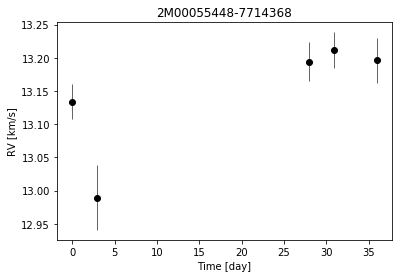

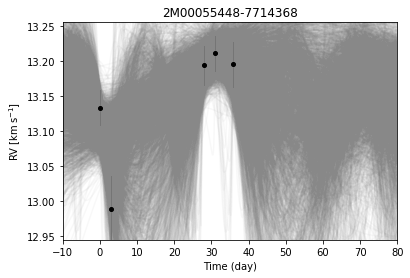

OSError: File exists: /home/cody/Binary Search/2M00055448-7714368/2M00055448-7714368.fits

In [2]:
# Now I have my table of Visits I want to look at. But now I'd like a bunch of little arrays to make things 
# a little easier to plot and I'd like to only keep 'JD' and 'VHELIO' I can probably use the 'NVISITS' in teh AllAverage
# to help organize things.
#First step is make empty arrays using AllAvgSimp with length 'NVISITS
from thejoker.sampler import TheJoker
from thejoker.sampler import JokerParams

from astropy.time import Time
from twobody import KeplerOrbit
from astropy.time import Time

from twobody.wrap import cy_rv_from_elements
from twobody.utils import ArrayProcessor

start = 0
end = 0
loop = 0
name = 0

for n in AllAvgSimp['NVISITS']:
    
    start = end
    end = end + n
    
    #Read in the dates that the object was observed on
    Date = AllVisSimp['JD'][start:end] - AllVisSimp['JD'][start]
    
    #Radial velocities that the object was observed to have with the units on km/s
    RV = AllVisSimp['VHELIO'][start:end]* u.km/u.s
    #Error each individual measurment
    err = AllVisSimp['VRELERR'][start:end] * u.km/u.s
    data = RVData( t = Date, rv = RV, stddev = err)
    
    #This makes a plot of the observed data. Odds are I'll want to get rid of this eventually but for now I keep it 
    #in becasue I'm afriad to deleate things I might need lator. 
    fig, ax = plt.subplots(1,1)
    ax = data.plot()
    ax.set_xlabel('Time [day]')
    ax.set_ylabel('RV [km/s]')
    thing = AllAvgSimp['APOGEE_ID'][name]    # Dummy variable to hold the name of the object
    plt.title(thing)
    
    #From The Joker that gets possible paramiters that fit the data. The range of max and minimum periods have no ryme 
    #or reason to them I just picked them becasue they seam reasonable. 
    params = JokerParams(P_min = 8*u.day, P_max= 512*u.day)
    
    
    joker = TheJoker(params)
    samples = joker.rejection_sample(data,n_prior_samples = 2**18)
    
    #Loop through all the different good samples that survive rejection. And find the Likelihood for each of them
    # and the Chi squared
    chi_2 = np.zeros(len(samples))
    chi_2_red = np.zeros(len(samples))
    ln_L = np.zeros(len(samples))
    for n in range(len(samples)):

        #For each of the samples read in their respective orbital paramiters. I haven't read in jitter becasue in all of
        #my cases I've set the jitter to be zero
        P = samples['P'][n]
        e = samples['e'][n]
        M0 = samples['M0'][n]
        omega = samples['omega'][n]
        K = samples['K'][n]
        v0 = samples['v0'][n]
        s = samples['jitter'][n]
        #t_foo = np.linspace(t[0], 200,1024) #make a lin space for the radial velocity plot. Must start at the starting point
                                            #of the data, if not then the radial velocity curves will be off set 

        #t_foo = Time(t_foo, format = 'mjd')
        t_dat = Time(Date, format = 'mjd')

        #t_foo = t_foo.tcb.mjd
        t_dat = t_dat.tcb.mjd

        #proc = ArrayProcessor(t_foo)
        proc2 = ArrayProcessor(t_dat)

        #t_foo, = proc.prepare_arrays()
        t_dat, = proc2.prepare_arrays()

        #t0  = t_foo[0]
        td0 = t_dat[0]

        #t0  = Time(t0 , format = 'mjd')
        td0 = Time(td0, format = 'mjd')


        #Several warnings pop up when running this. Something about certain time values giving "dubious year (Note 3/4)" 
        #But it runs fine without it
        #rv = cy_rv_from_elements(t_foo, P.to(u.day).value, 1., e, omega.to(u.radian).value,
        #                         M0.to(u.radian).value, t0.tcb.mjd, 
        #                         anomaly_tol = 1E-10, anomaly_maxiter = 128)

        rv_an = cy_rv_from_elements(t_dat, P.to(u.day).value, 1., e, omega.value,
                                 M0.value, td0.tcb.mjd, 
                                 anomaly_tol = 1E-10, anomaly_maxiter = 128)
        #rv = K*rv + v0

        #rv_an is the analytical radial velocity evaluated at the times that we made the actual observations
        rv_an = K*rv_an + v0

        #plt.plot(t_foo,rv,color='#555555' ,linestyle = '-', marker = '', alpha = 0.05 + 4./(len(samples) + 4.), rasterized = True)

        #data = RVData(t = t, rv=rv_dat, stddev = err)
        #ax = data.plot()
        #ax.set_xlim(-5,200)
        #ax.set_xlabel("Time [day]")
        #ax.set_ylabel("RV [km/s]")
        #Now that I have an 'analytic' radial velocity i want to find the ln_likelihood
        diff = (RV - rv_an)**2
        chi_2[n] = sum(diff /((err)**2 + s**2))
        chi_term = diff /((err)**2  + s**2)
        # Can't use a reduced chi squared because often the number of data points we have is less than the number
        # of paramiters to our best fit equation. 
        #chi_2_red[n] = chi_2[n] / (len(data) - 6)
        thing_2b_summed = chi_term + np.log(2*np.pi*(err.value**2 + s.value**2))
        ln_L[n] = -0.5*sum(thing_2b_summed)

    fig, ax = plt.subplots(1,1)
    t_grid = np.linspace(-10,80,1024)
    plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data = data,
                  ax = ax, plot_kwargs=dict(color='#888888'))
    plt.title(thing)
    plt.xlabel('Time (day)')
    plt.show(ax)
    newpath = r'/home/cody/Binary Search/'+str(AllAvgSimp['APOGEE_ID'][name])
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    #Saving the plot with all the samples
    name_holder = AllVisSimp['APOGEE_ID'][name]
    fig.savefig('/home/cody/Binary Search/'+str(AllAvgSimp['APOGEE_ID'][name]) +'/P' +str(AllAvgSimp['APOGEE_ID'][name]) + '.png')
    
    plt.close()
    #Save the paramiters that The Joker got for the orbit. The varable 'samples' is some weird type of object that I can't
    #figure out how\ to save. So instead lets turn it into a table, save that, and then it'll be easier to work wtih?
    Samples_Table = Table()
    Samples_Table['P'] = samples['P']
    Samples_Table['M0'] = samples['M0']
    Samples_Table['e'] = samples['e']
    Samples_Table['omega'] = samples['omega']
    Samples_Table['jitter'] = samples['jitter']
    Samples_Table['K'] = samples['K']
    Samples_Table['v0'] = samples['v0']
    Samples_Table['ln_L'] = ln_L
    Samples_Table['Chi Squared'] = chi_2
    Samples_Table.write("/home/cody/Binary Search/"+str(AllAvgSimp['APOGEE_ID'][name])+"/" +str(AllAvgSimp['APOGEE_ID'][name])+'.fits', format = 'fits' )
       

    loop += 1
    name += 1
  
    if loop > 0:
        break
    if name == int(len(AllAvgSimp['APOGEE_ID'])*.25):
        print(" 25% Done")
    if name == int(len(AllAvgSimp['APOGEE_ID'])*0.5):
        print(" 50% Done")
    if name == int(len(AllAvgSimp['APOGEE_ID'])*.75):
        print(" 75% Done")

In [28]:
AllAverage = Table(fits.getdata('/home/cody/Binary Search/allMC.avg.nocut.fits',1))
AllAvgSimp = Table(fits.getdata('/home/cody/Binary Search/AllAvgSimp.fits',1))
AllAvgSimp['LOGG']

3.1330225
4.9001
-9999.0
-9999.0
-9999.0
-9999.0
-9999.0
-9999.0
-9999.0
-9999.0
2.5699


In [11]:

AllAvgSimp_foo = AllAvgSimp
#I need to simplify again eliminating any observations that don't both have a TEFF value or a LOGG value. 
# Because I will need both of these in order to calculate things like mass and luminocity. 
AllAvgSimp_foo['TEFF'][AllAvgSimp_foo['TEFF'] < 0 ] = np.nan #replaces bad values with nan
AllAvgSimp_foo['LOGG'][AllAvgSimp_foo['LOGG'] < 0 ] = np.nan
AllAvgSimp_foo['FE_H'][AllAvgSimp_foo['FE_H'] < -100] = np.nan

AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['TEFF'])] #gets rid of nan's
AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['LOGG'])]
AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['FE_H'])]

/home/cody/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [8]:
AllAvgSimp['LOGG']

3.1330225
4.9001
nan
nan
nan
nan
nan
nan
nan
nan
2.5699


1033

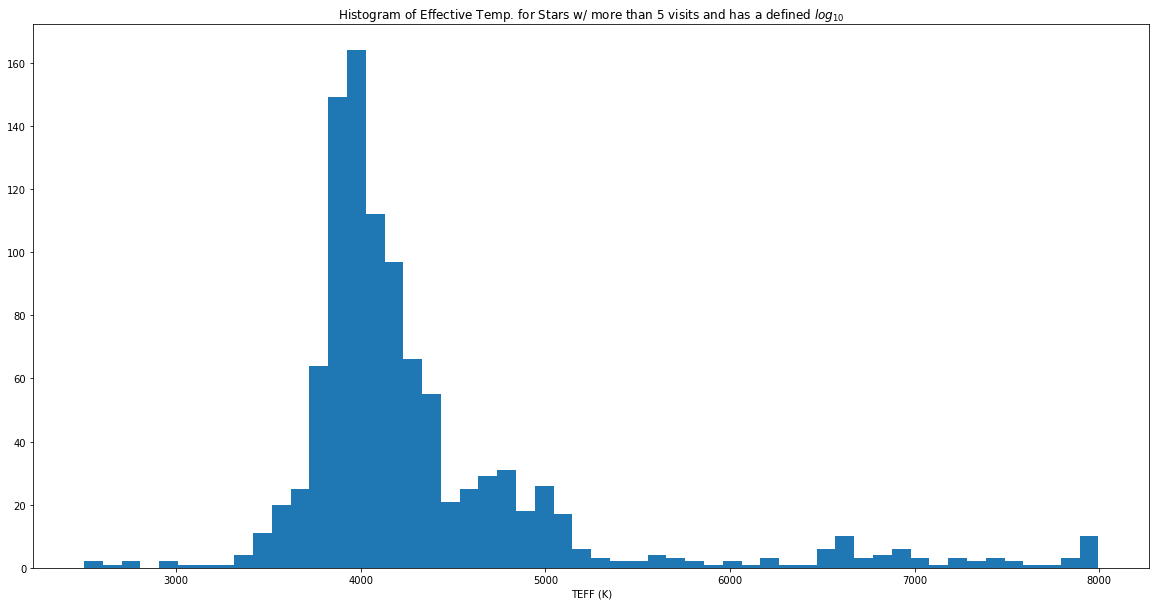

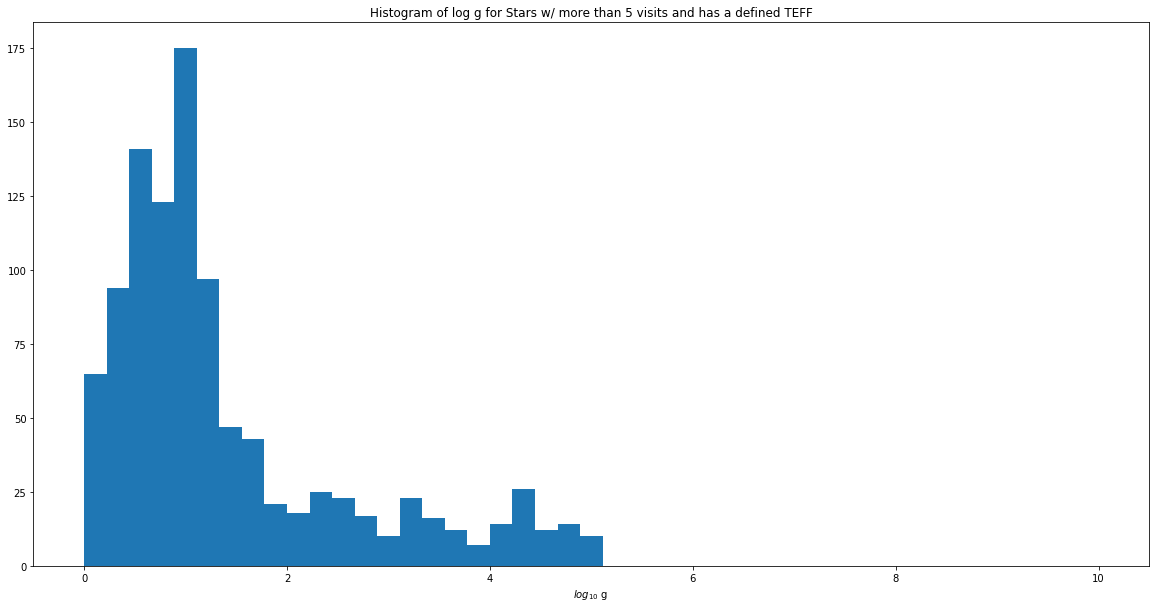

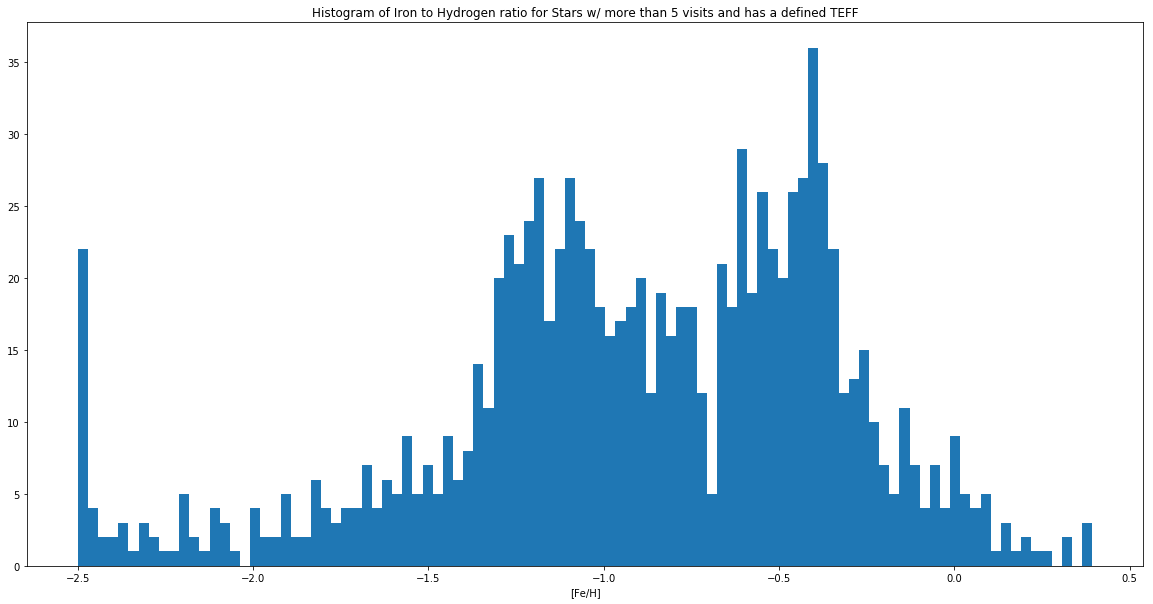

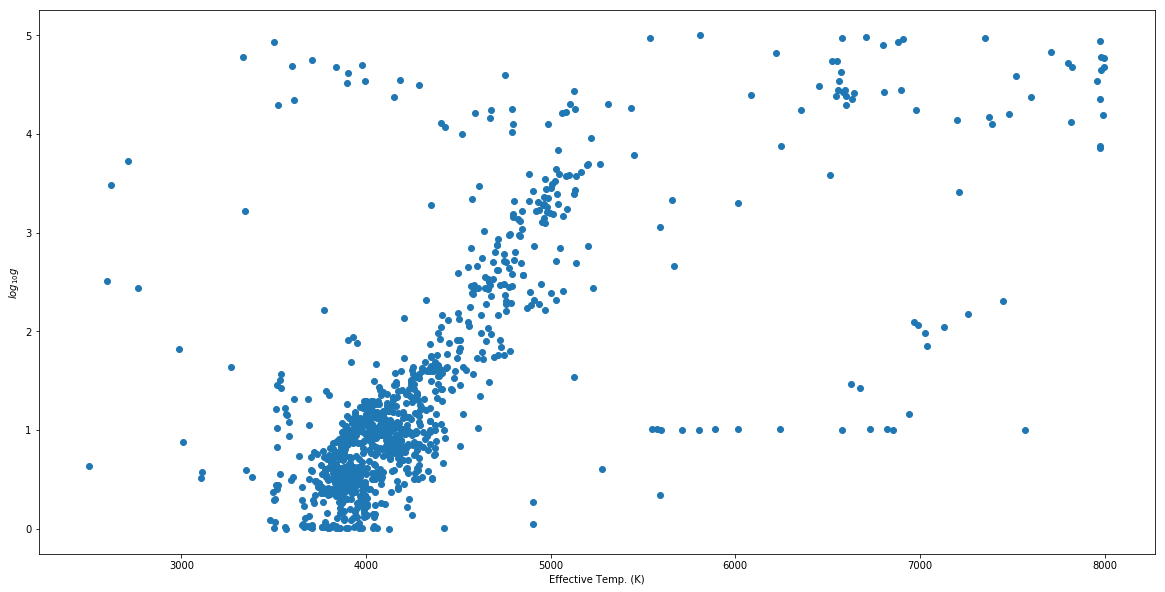

In [12]:
plt.subplots(1,1,figsize = (20,10))
plt.hist(AllAvgSimp_foo['TEFF'], bins = 'auto')
plt.title('Histogram of Effective Temp. for Stars w/ more than 5 visits and has a defined $log_{10}$')
plt.xlabel('TEFF (K)')

plt.subplots(1,1,figsize = (20,10))
plt.hist(AllAvgSimp_foo['LOGG'], bins = 'auto', range = {0, 10})
plt.title('Histogram of log g for Stars w/ more than 5 visits and has a defined TEFF')
plt.xlabel('$log_{10}$ g ')

plt.subplots(1,1, figsize = (20,10))
plt.scatter(AllAvgSimp_foo['TEFF'],AllAvgSimp_foo["LOGG"])
plt.xlabel('Effective Temp. (K)')
plt.ylabel('$log_{10}g$')
len(AllAvgSimp_foo)

In [37]:
# I need to break the data into two groups, Red Giant (RG) and Subgiant (SG) because how I find things like mass
# and radius will depend on the class of the object. 
AllAvgSimp = Table(fits.getdata('/home/cody/Binary Search/AllAvgSimp.fits',1))
AllAvgSimp_foo = AllAvgSimp

#Get rid of bad tempurature and log(g) values. 
AllAvgSimp_foo['TEFF'][AllAvgSimp_foo['TEFF'] < 0 ] = np.nan #replaces bad values with nan
AllAvgSimp_foo['LOGG'][AllAvgSimp_foo['LOGG'] < 0 ] = np.nan
AllAvgSimp_foo['FE_H'][AllAvgSimp_foo['FE_H'] < -100] = np.nan


AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['TEFF'])] #gets rid of nan's
AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['LOGG'])]
AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['FE_H'])]
# I only want to look at the Red Giant group right now so I'm going to ignore
AAS_RG = AllAvgSimp_foo
AAS_RG['TEFF'][AAS_RG['TEFF'] >= 5500  ] = np.nan 
AAS_RG['LOGG'][AAS_RG['LOGG'] >= 3.7 + 0.1*AAS_RG['FE_H'] ] = np.nan

#Now get rid of nan's
AAS_RG = AAS_RG[np.isfinite(AAS_RG['TEFF'])] #gets rid of nan's
AAS_RG = AAS_RG[np.isfinite(AAS_RG['LOGG'])]

# Down the road we'll also have problems with AK and K so we need to get rid of any AK values that are -9999.9999
AAS_RG['AK_WISE'][AAS_RG['AK_WISE'] < 0  ] = np.nan #replaces bad values with nan
AAS_RG = AAS_RG[np.isfinite(AAS_RG['AK_WISE'])]

AAS_RG['AK_TARG'][AAS_RG['AK_TARG'] < 0  ] = np.nan #replaces bad values with nan
AAS_RG = AAS_RG[np.isfinite(AAS_RG['AK_TARG'])]

Text(0,0.5,'$log_{10}g$')

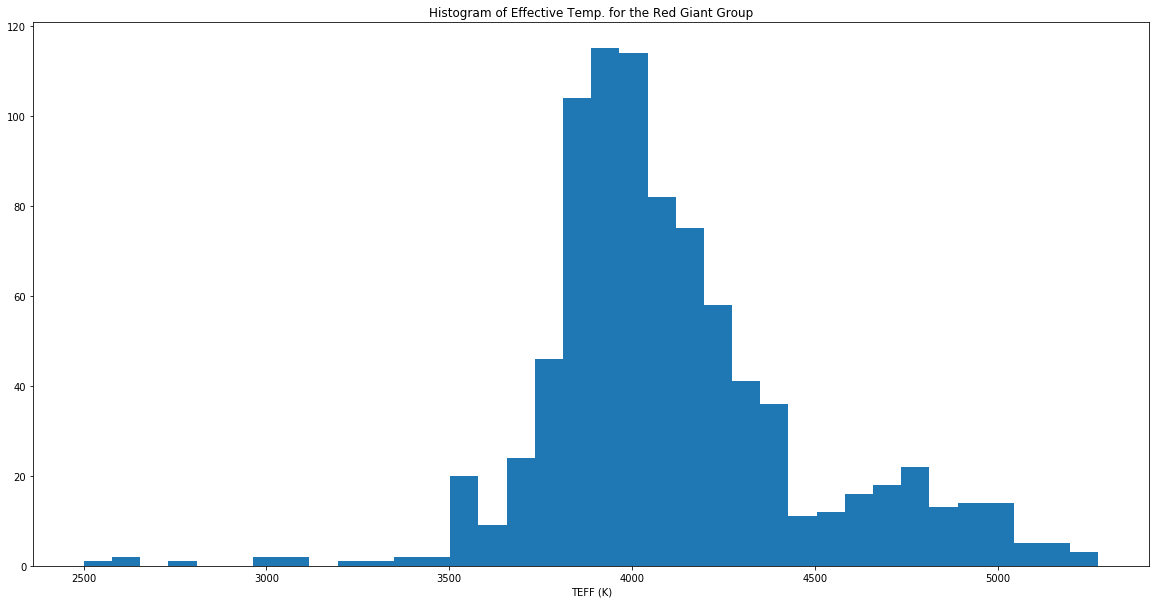

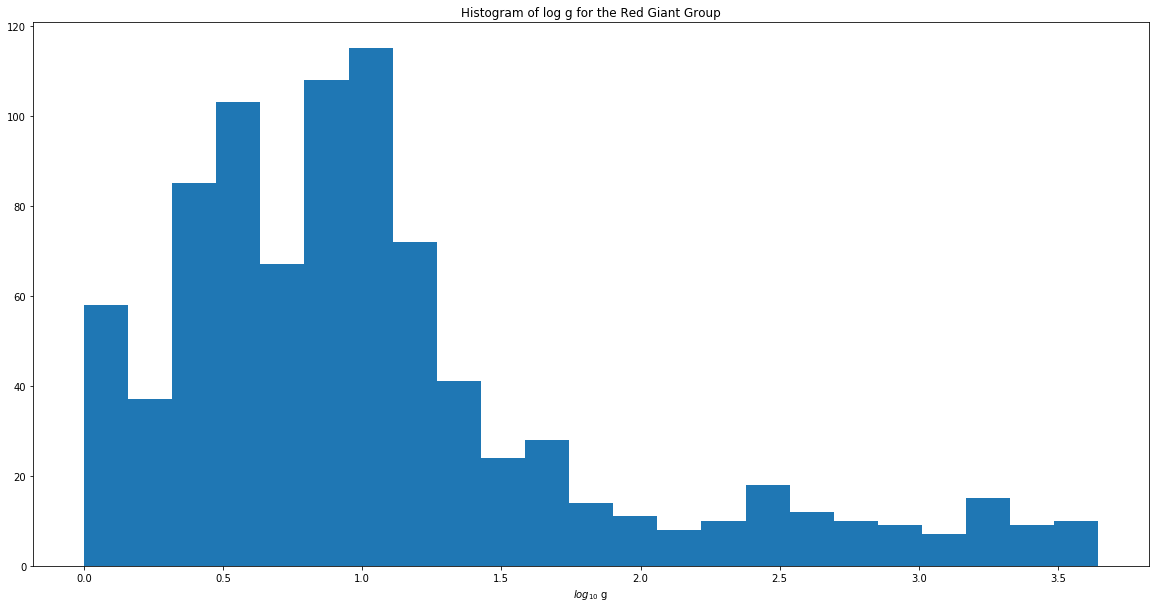

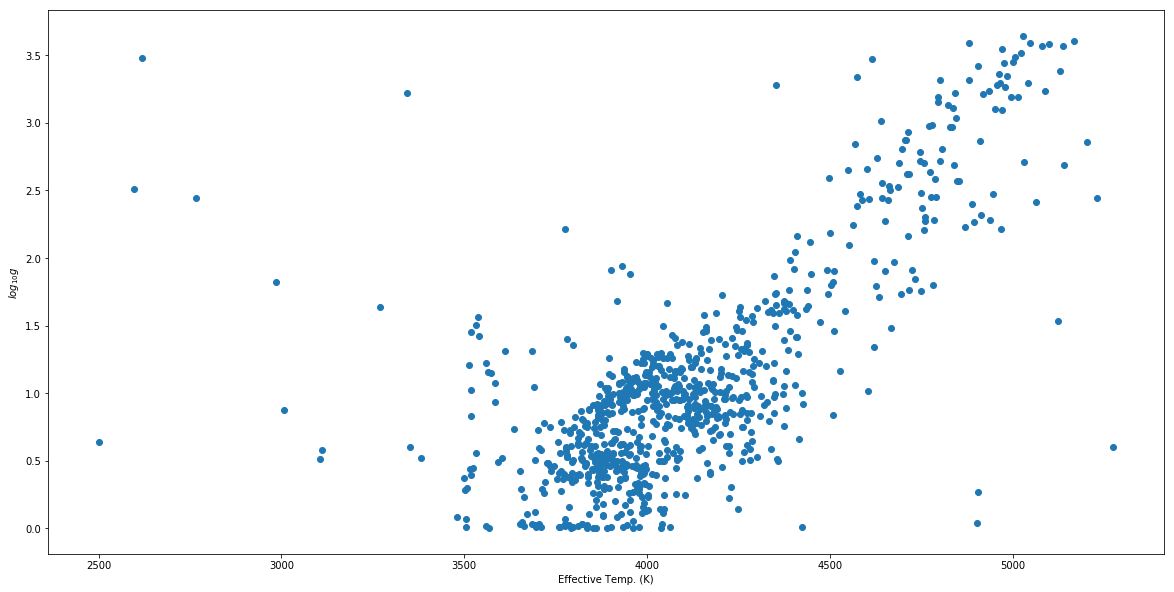

In [15]:
plt.subplots(1,1,figsize = (20,10))
plt.hist(AAS_RG['TEFF'], bins = 'auto')
plt.title('Histogram of Effective Temp. for the Red Giant Group')
plt.xlabel('TEFF (K)')

plt.subplots(1,1,figsize = (20,10))
plt.hist(AAS_RG['LOGG'], bins = 'auto')
plt.title('Histogram of log g for the Red Giant Group')
plt.xlabel('$log_{10}$ g ')

plt.subplots(1,1, figsize = (20,10))
plt.scatter(AAS_RG['TEFF'],AAS_RG["LOGG"])
plt.xlabel('Effective Temp. (K)')
plt.ylabel('$log_{10}g$')

In [32]:
AllAvgSimp = Table(fits.getdata('/home/cody/Binary Search/AllAvgSimp.fits',1))
AllAvgSimp_foo = AllAvgSimp

AllAvgSimp_foo['TEFF'][AllAvgSimp_foo['TEFF'] < 0 ] = np.nan #replaces bad values with nan
AllAvgSimp_foo['LOGG'][AllAvgSimp_foo['LOGG'] < 0 ] = np.nan

AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['TEFF'])] #gets rid of nan's
AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['LOGG'])]
#This part above this line is because for some reason AllAvgSimp_foo gets changed when I start changing AAS_RG or
#AAS_SG i don't know why so I'm just re-creating these variables each time.

AAS_SG1 = AllAvgSimp_foo
AAS_SG1['TEFF'][AAS_SG1['TEFF'] <= 4800] = np.nan #replaces bad values with nan
AAS_SG1['TEFF'][AAS_SG1['TEFF'] > 5500] = np.nan
AAS_SG1['LOGG'][AAS_SG1['LOGG'] < 3.7 + 0.1*AAS_SG1['FE_H'] ] = np.nan # this got rid of my entire data set...
#AAS_SG['LOGG'][if AAS_SG > 5500: ]
#Now get rid of nan's
AAS_SG1 = AAS_SG1[np.isfinite(AAS_SG1['TEFF'])] #gets rid of nan's
#AAS_SG = AAS_SG[np.isfinite(AAS_SG['LOGG'])]
AAS_SG1

/home/cody/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,TARGFLAGS,SURVEY,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,PARAM [9],FPARAM [9],"PARAM_COV [9,9]","FPARAM_COV [9,9]",TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,Y_FE,ND_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,Y_FE_ERR,ND_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,Y_FE_FLAG,ND_FE_FLAG,ELEM_CHI2 [26],ELEMFLAG [26],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],"FPARAM_CLASS [23,9]",CHI2_CLASS [23]
str57,str36,str59,str38,str18,str6,int32,str5,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,str147,str14,int32,int32,int32,int16,float32,int32,str165,int32,str58,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,str5,str4,str7,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,int32,str189,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str23,str14,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str17,float32,float32,int16,int16,float32,float32,str20,str1044,str917,int32,int32,float32,float32
apogee.apo25m.s.stars.SMC-1.2M00055448-7714368,SMC-1.2M00055448-7714368,apogee.apo25m.s.t9-l31c.SMC-1.2M00055448-7714368,apStar-t9-2M00055448-7714368.fits,2M00055448-7714368,lco25m,5497,SMC1,11.903,0.024,11.337,0.028,11.274,0.026,1.477008,-77.243561,306.173995093,-39.5966520921,0,0,0,"APOGEE2_SFD_DERED,APOGEE2_SHORT,APOGEE2_NORMAL_SAMPLE,APOGEE2_ONEBIN_GT_0_3",apogee2s,0 .. 5,5,1,0,181.966,0,,0,,13.1601,0.0918901,0.0139853,0.0292711

In [33]:
AllAvgSimp = Table(fits.getdata('/home/cody/Binary Search/AllAvgSimp.fits',1))
AllAvgSimp_foo = AllAvgSimp

AllAvgSimp_foo['TEFF'][AllAvgSimp_foo['TEFF'] < 0 ] = np.nan #replaces bad values with nan
AllAvgSimp_foo['LOGG'][AllAvgSimp_foo['LOGG'] < 0 ] = np.nan

AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['TEFF'])] #gets rid of nan's
AllAvgSimp_foo = AllAvgSimp_foo[np.isfinite(AllAvgSimp_foo['LOGG'])]
#This part above this line is because for some reason AllAvgSimp_foo gets changed when I start changing AAS_RG or
#AAS_SG i don't know why so I'm just re-creating these variables each time.

AAS_SG2 = AllAvgSimp_foo

AAS_SG2['TEFF'][AAS_SG2['TEFF'] < 5500] = np.nan
AAS_SG2['LOGG'][AAS_SG2['LOGG'] > 4.0 - (7.5*10**-5)*(AAS_SG2['FE_H']-8000) ] = np.nan # this got rid of my entire data set...
#AAS_SG['LOGG'][if AAS_SG > 5500: ]
#Now get rid of nan's
AAS_SG2 = AAS_SG2[np.isfinite(AAS_SG2['TEFF'])] #gets rid of nan's
#AAS_SG = AAS_SG[np.isfinite(AAS_SG['LOGG'])]
AAS_SG2

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,TARGFLAGS,SURVEY,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,PARAM [9],FPARAM [9],"PARAM_COV [9,9]","FPARAM_COV [9,9]",TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,Y_FE,ND_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,Y_FE_ERR,ND_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,Y_FE_FLAG,ND_FE_FLAG,ELEM_CHI2 [26],ELEMFLAG [26],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],"FPARAM_CLASS [23,9]",CHI2_CLASS [23]
str57,str36,str59,str38,str18,str6,int32,str5,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,str147,str14,int32,int32,int32,int16,float32,int32,str165,int32,str58,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,str5,str4,str7,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,int32,str189,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str23,str14,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str17,float32,float32,int16,int16,float32,float32,str20,str1044,str917,int32,int32,float32,float32
apogee.apo25m.s.stars.SMC-1.2M00060328-7711352,SMC-1.2M00060328-7711352,apogee.apo25m.s.t9-l31c.SMC-1.2M00060328-7711352,apStar-t9-2M00060328-7711352.fits,2M00060328-7711352,lco25m,5497,SMC1,10.153,0.026,9.958,0.024,9.891,0.021,1.513674,-77.193138,306.178644177,-39.6475978057,0,0,0,"APOGEE2_NO_DERED,APOGEE2_TELLURIC",apogee2s,0 .. 5,7,1,0,367.24423,0,,0,,25.45955,0.199624,0.054518465,0.0293266,25.7039,0.240747,0.0153715,0.0318535,25

In [124]:
# For now lets just look at the red giant group. AAS_RG, The Bolometric Correction for these stars is 
BC_K_RG = (6.8 - 0.2*AAS_RG["FE_H"])*(3.96 - np.log10(AAS_RG["TEFF"]))
K0 = AAS_RG["K"] - AAS_RG["AK_TARG"]
m_bol = K0 + BC_K_RG

Text(0.5,0,'Bolometric Correction')

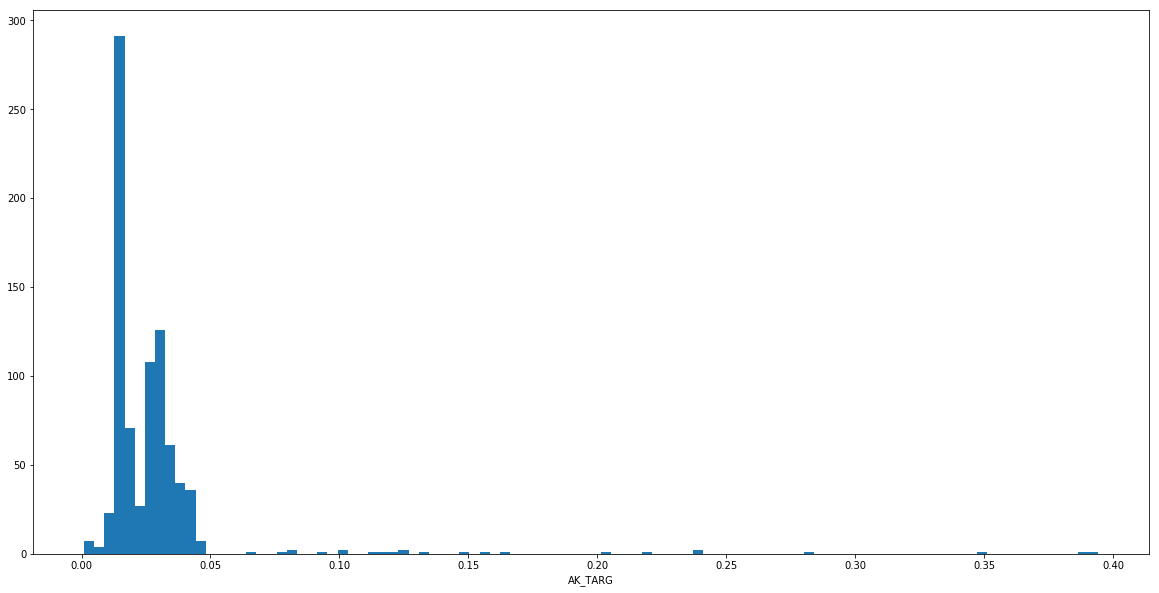

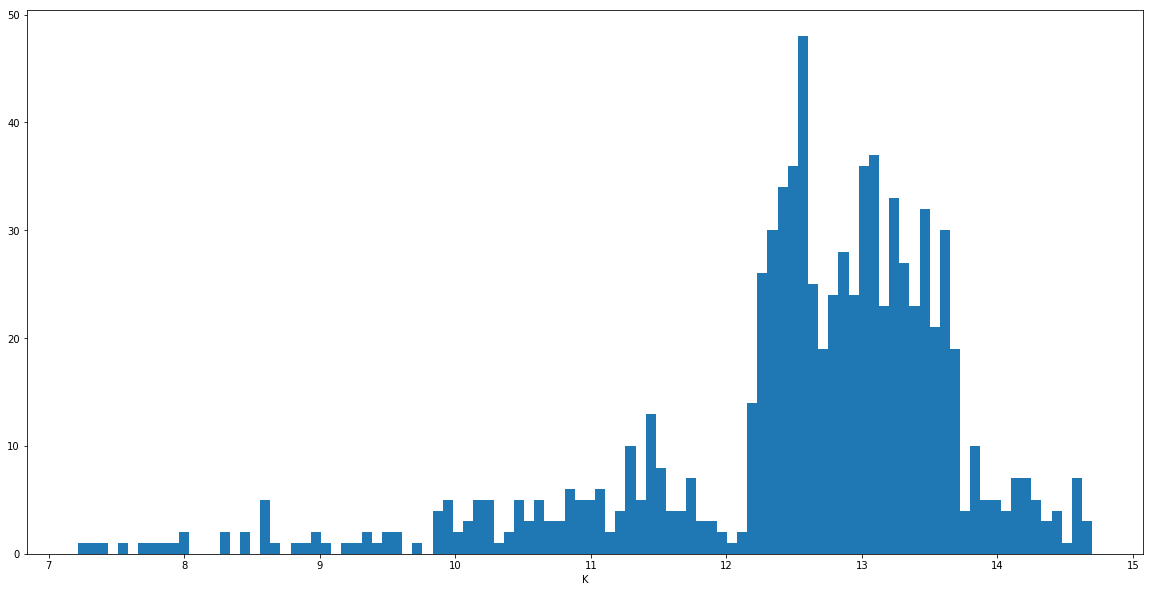

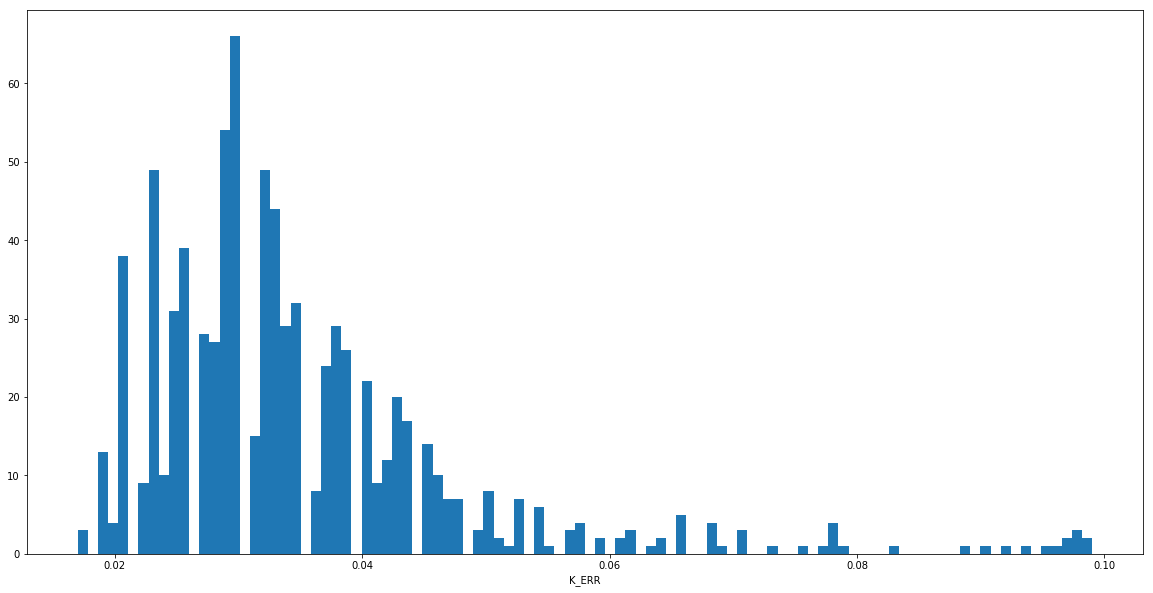

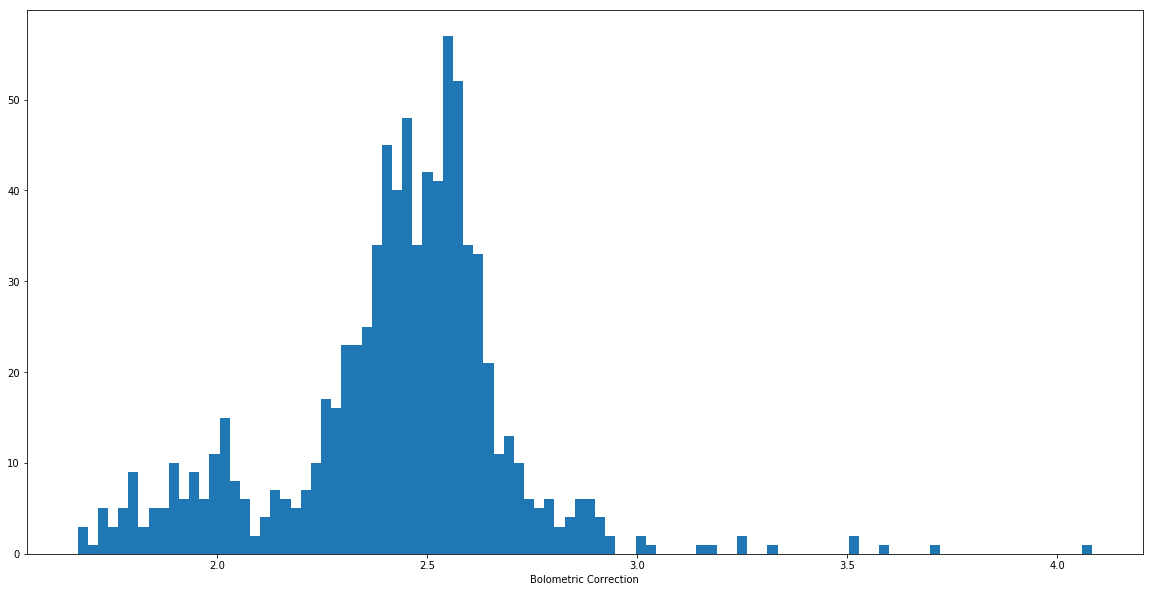

In [125]:
plt.subplots(1,1,figsize = (20,10))
plt.hist(AAS_RG['AK_TARG'], bins = 100)
plt.xlabel('AK_TARG')

plt.subplots(1,1,figsize = (20,10))
plt.hist(AAS_RG['K'], bins = 100)
plt.xlabel('K')

plt.subplots(1,1,figsize = (20,10))
plt.hist(AAS_RG['K_ERR'], bins = 100)
plt.xlabel('K_ERR')

plt.subplots(1,1,figsize = (20,10))
plt.hist(AAS_RG['BC_K_RG'], bins = 100)
plt.xlabel('Bolometric Correction')

In [126]:
# Next I want to look at the absolute magnitude, Luminocity, Radius, and Mass of the primary star. To find the
# absolute magnitude I the distances, but to do this I need to know what Cloud I was looking at. So i can just look
# at the first letter of the AAS_RG["FIELD"] string and then set the distance based on the aproximate distance of the
# large and small magelanic cloud
M_bol = np.zeros(len(AAS_RG))
for i in range(len(AAS_RG)):
    field = AAS_RG["FIELD"][i] #String of the field that the star was seen in.
    if field[0] == 'S':     # SMC
        d = (2*10**5 * u.lyr).to(u.pc)  #Distance to the SMC if parsecs, diamiter of the SMC is about 2 kpc
        M_bol[i] = m_bol[i] - 5*np.log10(d.value) + 5
    elif field[0] == 'L':
        d = (1.6*10**5 *u.lyr).to(u.pc) #Distance to the LMC, diamiter is about 4.3 kpc
        M_bol[i] = m_bol[i] - 5*np.log10(d.value) + 5
    else:
        M_bol[i] = np.nan   #Something went wrong so set the Absolute magnitude to nan
        print("Field deons't start with an S or an L so something went wrong, probably your fault.")

In [127]:
#Now for Luminocity Radius and Mass,

L = 10**(-0.4*(M_bol - 4.77)) * u.solLum
R = np.sqrt( L / (4 * np.pi * sigma_sb * (AAS_RG["TEFF"]*u.K)**4 ) ).to(u.solRad)
M = ((10**(AAS_RG['LOGG']))*(u.cm/u.s**2)*R**2 / G).to(u.solMass)

Text(0,0.5,'Number of Objects')

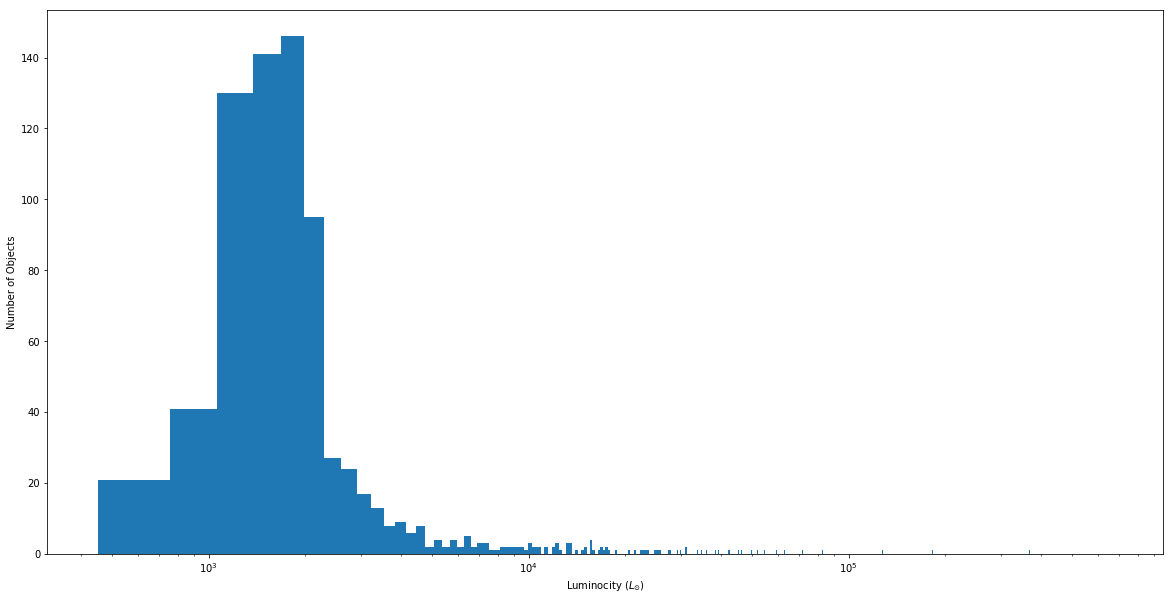

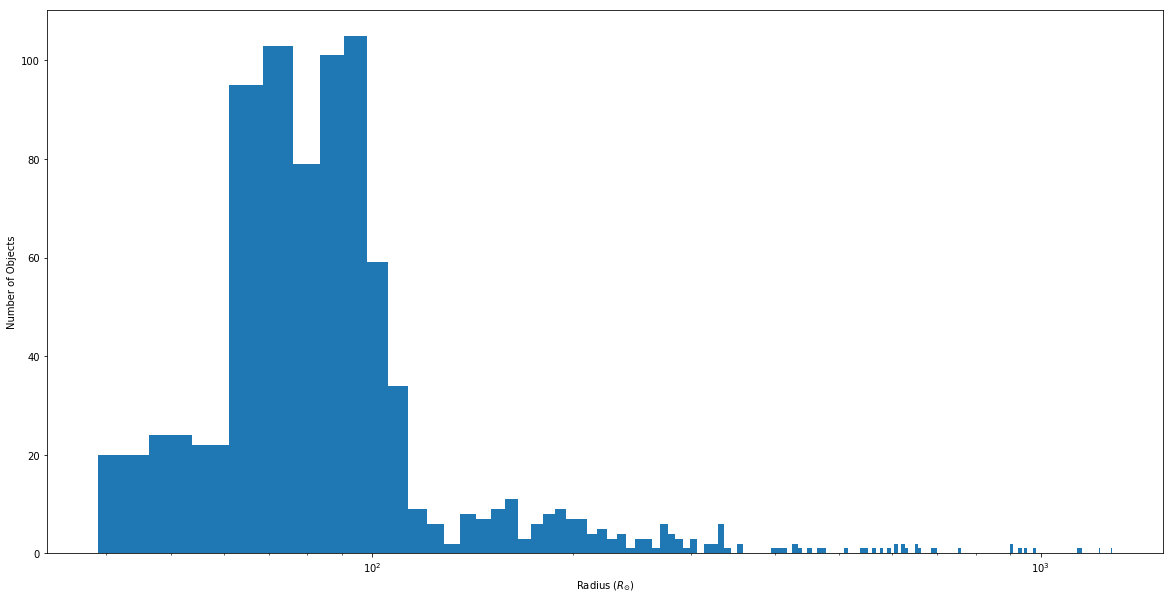

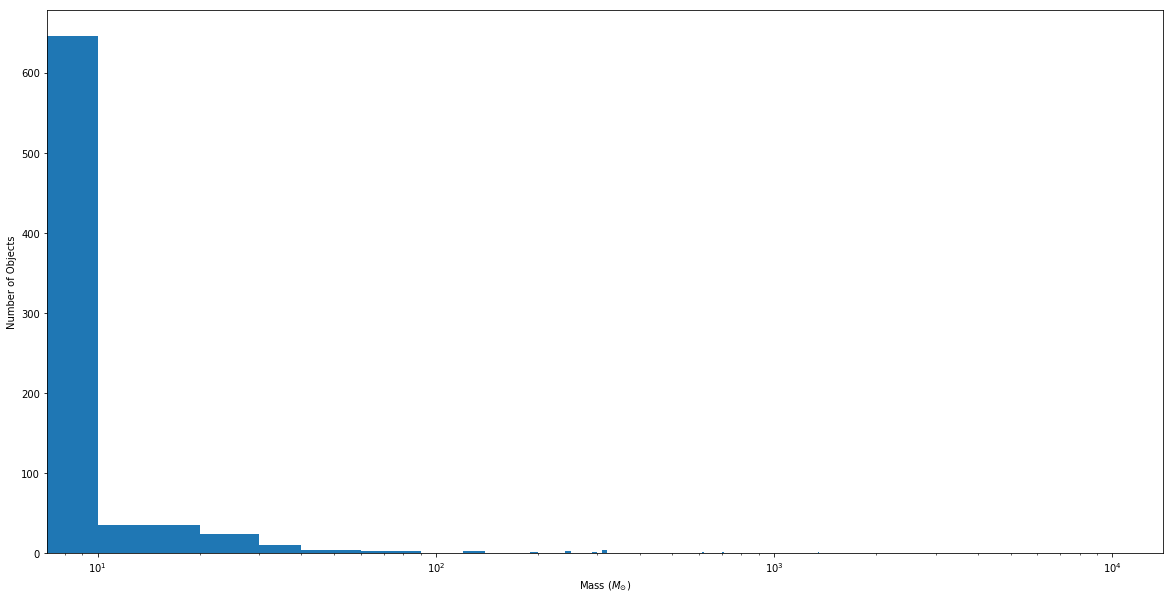

In [128]:
plt.subplots(1,1, figsize = (20,10))
plt.hist(L.value, bins = 'auto')
plt.xscale('log')
plt.xlabel('Luminocity ($L_{\odot})$')
plt.ylabel('Number of Objects')

plt.subplots(1,1, figsize = (20,10))
plt.hist(R.value, bins = 'auto')
plt.xscale('log')
plt.xlabel('Radius ($R_{\odot})$')
plt.ylabel('Number of Objects')

plt.subplots(1,1, figsize = (20,10))
plt.hist(M.value, bins = 1000, range = {0,10000})
plt.xscale('log')
plt.xlabel('Mass ($M_{\odot})$')
plt.ylabel('Number of Objects')

In [129]:
AAS_RG['BC_K_RG'] = BC_K_RG
AAS_RG["L"] = L
AAS_RG['R'] = R
AAS_RG['M'] = M
AAS_RG['m_bol']=m_bol
AAS_RG['M_bol'] = M_bol
print (max(M))

27808.8393381922 solMass


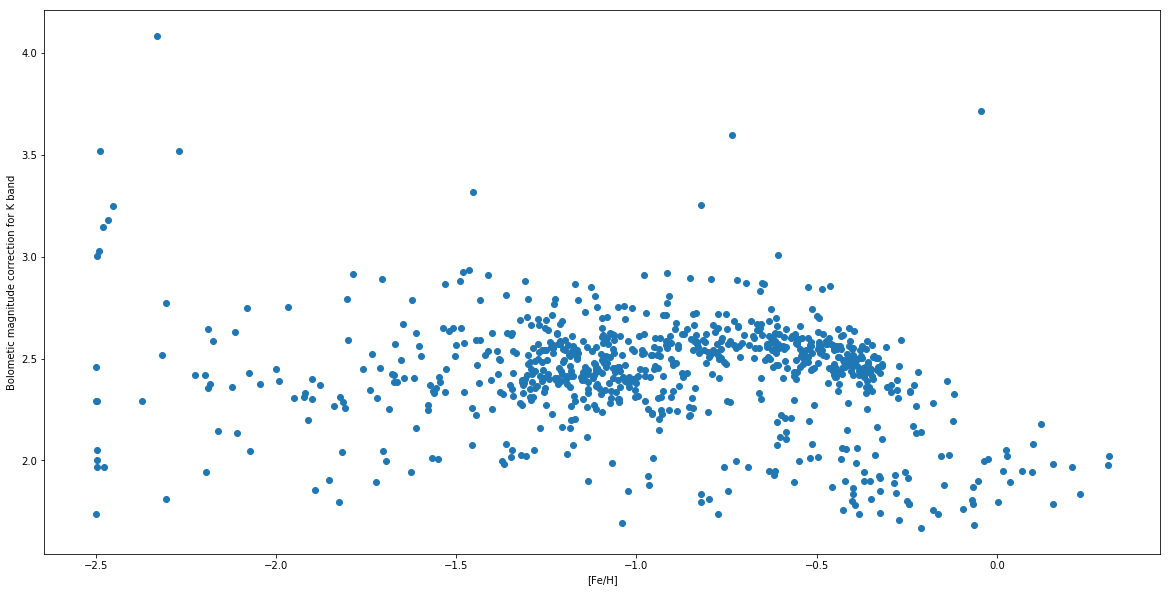

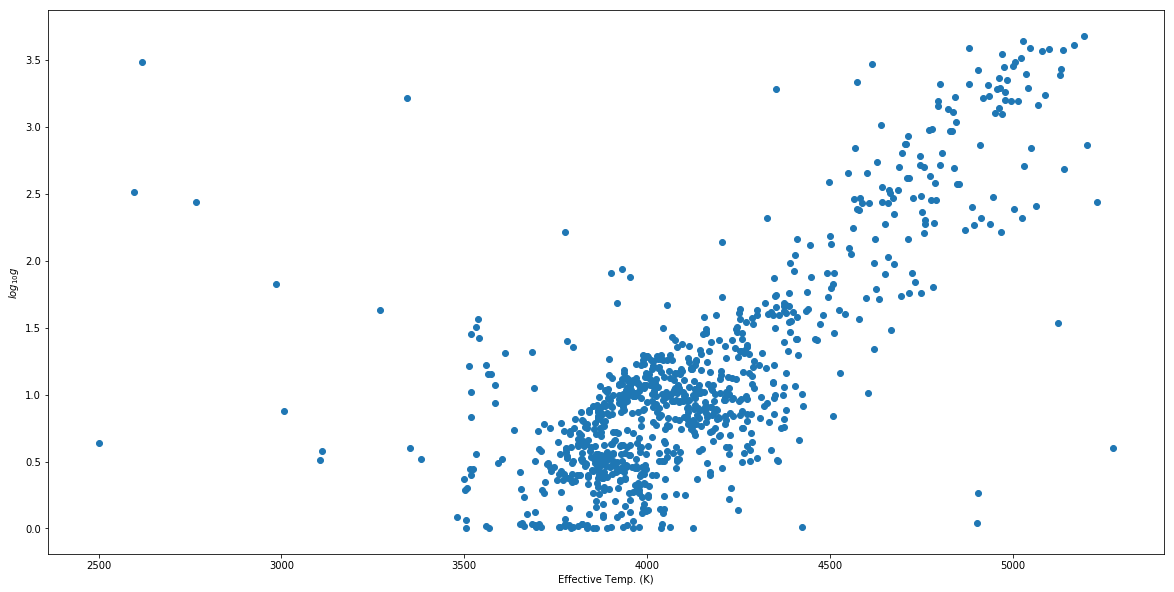

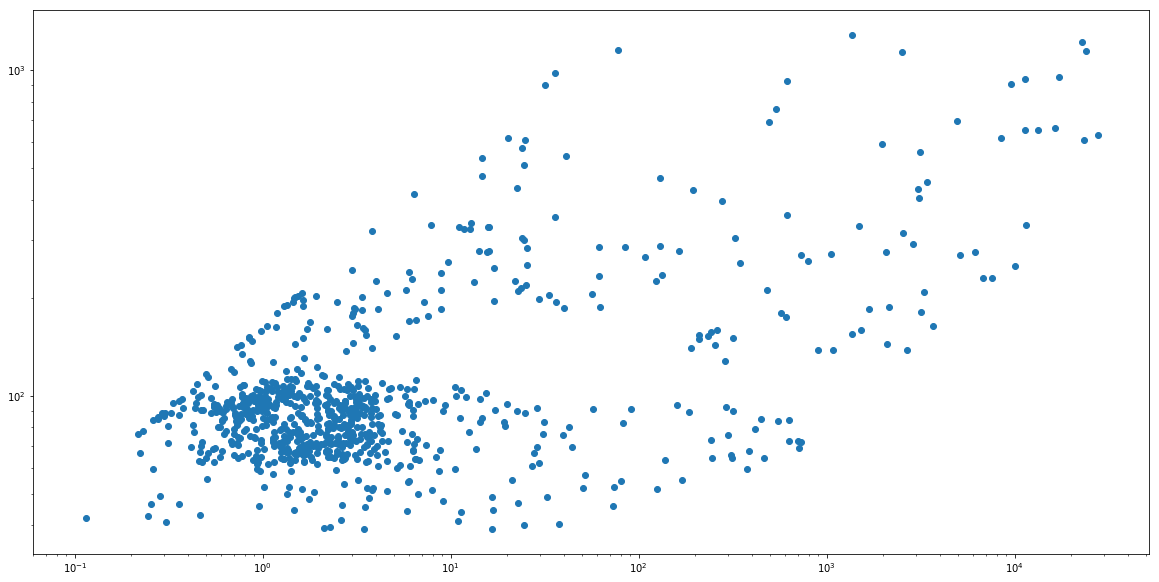

In [130]:
plt.subplots(1,1,figsize = (20,10))
plt.scatter(AAS_RG["FE_H"],AAS_RG["BC_K_RG"])
plt.xlabel('[Fe/H]')
plt.ylabel('Bolometic magnitude correction for K band')
plt.subplots(1,1, figsize = (20,10))
plt.scatter(AllAvgSimp_foo['TEFF'],AllAvgSimp_foo["LOGG"])
plt.xlabel('Effective Temp. (K)')
plt.ylabel('$log_{10}g$')


plt.subplots(1,1,figsize = (20,10))
plt.scatter(AAS_RG["M"],AAS_RG["R"])
plt.xscale('log')
plt.yscale('log')

In [55]:
len(AAS_RG)

825

In [54]:
AAS_RG['TEFF','LOGG','FE_H','K','AK_TARG', 'BC_K_RG','m_bol','M_bol','L','R','M'][AAS_RG['M'] > 100]

TEFF,LOGG,FE_H,K,AK_TARG,BC_K_RG,m_bol,M_bol,L,R,M
,,,,,,,,solLum,solRad,solMass
float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
4823.102,3.1330225,-0.35304624,11.274,0.015220589,1.9009159,13.159696,-5.778324976986827,16570.28548377539,184.35950943920216,1683.7824922742666
4613.809,3.4700992,-0.15421508,13.811,0.0171173,2.0215223,15.815405,-3.1226157103242294,1435.6424261324703,59.30036161274361,378.570039385736
4205.4517,1.7257049,-0.2742507,7.514,0.015088489,2.304514,9.803425,-9.134595767086925,364618.1698322517,1137.489247591063,2509.1803583040705
4835.977,3.1122708,-0.28519115,11.891,0.007343642,1.8892224,13.772879,-5.165141955441417,9420.127526762484,138.26535292271865,902.8798037612481
4852.2983,2.5698907,-0.5618288,9.986,0.018601134,1.894352,11.861751,-7.076269999569835,54765.61888518152,331.14062542018047,1485.4158206821676
4569.833,2.8450582,0.30967996,10.217,0.014951709,2.0220904,12.224138,-6.7138823424043075,39224.09543979648,315.9579298218122,2548.291429369098
4500.432,2.1837535,-0.319004,8.834,0.015131279,2.1054418,10.924311,-8.013709918087901,129862.56218349742,592.7710655505006,1956.4098887120101
4795.828,3.1538634,-0.24589404,13.225,0.015904516,1.9118552,15.120951,-3.8170699034394637,2721.6229682819176,75.56839643053375,296.8084320582241


In [265]:
iso_meanM = np.zeros(len(AAS_RG))
iso_medianM = np.zeros(len(AAS_RG))
iso_stdM = np.zeros(len(AAS_RG))

iso_meanL = np.zeros(len(AAS_RG))
iso_medianL = np.zeros(len(AAS_RG))
iso_stdL = np.zeros(len(AAS_RG))

for j in range(len(AAS_RG)): 
    star_teff = AAS_RG['TEFF'][j]

    star_logg = AAS_RG['LOGG'][j]
    star_feh  = AAS_RG['FE_H'][j]
    
   
    gd, = np.where(( (np.abs(iso['LOGTE']-np.log10(star_teff)) < 0.1) &
                    (np.abs(iso['LOGG']-star_logg) < 0.1) &
                    (np.abs(iso['FEH']-star_feh) < 0.1) ) )
    # This if loop is to check that any good values got found. If the array is empty then when i find mean and the like
    # it gives me some warnings about dividing by zero. 
    if len(gd) > 0:
        iso_meanM[j] = np.mean(iso['MASS'][gd])
        iso_medianM[j] = np.median(iso["MASS"][gd])
        iso_stdM[j] = np.std(iso["MASS"][gd])

        iso_meanL[j] = np.mean(iso['LOGL'][gd])
        iso_medianL[j] = np.median(iso["LOGL"][gd])
        iso_stdL[j] = np.std(iso["LOGL"][gd])
    else:
        iso_meanM[j] = np.nan
        iso_medianM[j] = np.nan
        iso_stdM[j] = np.nan

        iso_meanL[j] = np.nan
        iso_medianL[j] = np.nan
        iso_stdL[j] = np.nan
AAS_RG['ISO_MEANM'] = iso_meanM
AAS_RG["ISO_MEDIANM"] = iso_medianM
AAS_RG['ISO_STDM'] = iso_stdM

AAS_RG['ISO_MEANL'] = iso_meanL
AAS_RG["ISO_MEDIANL"] = iso_medianL
AAS_RG['ISO_STDL'] = iso_stdL


# I would like to know why the values I've gotten are so far off from what the values you get from the ISO table. So i'm going to make a histogram of the times the difference between iso and my values are greater or less than one standard deviation of the ISO values. 
## Take the mass calculated by equation 14 in the Troup. paper, and subtract the average M given from the iso chart.

/home/cody/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/cody/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5,0,'FE_H')

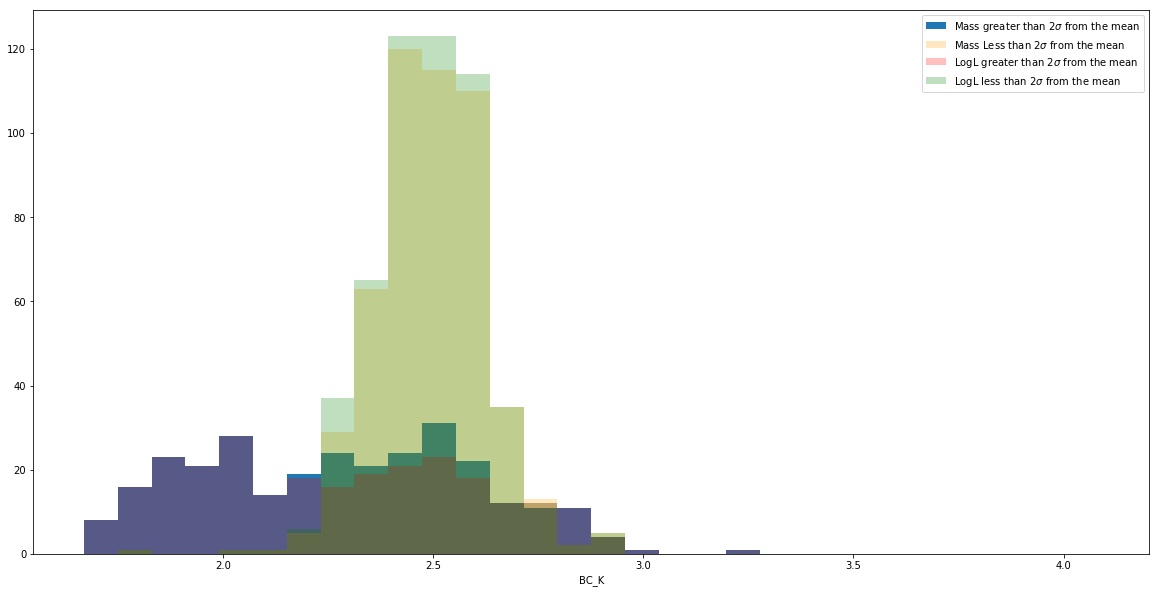

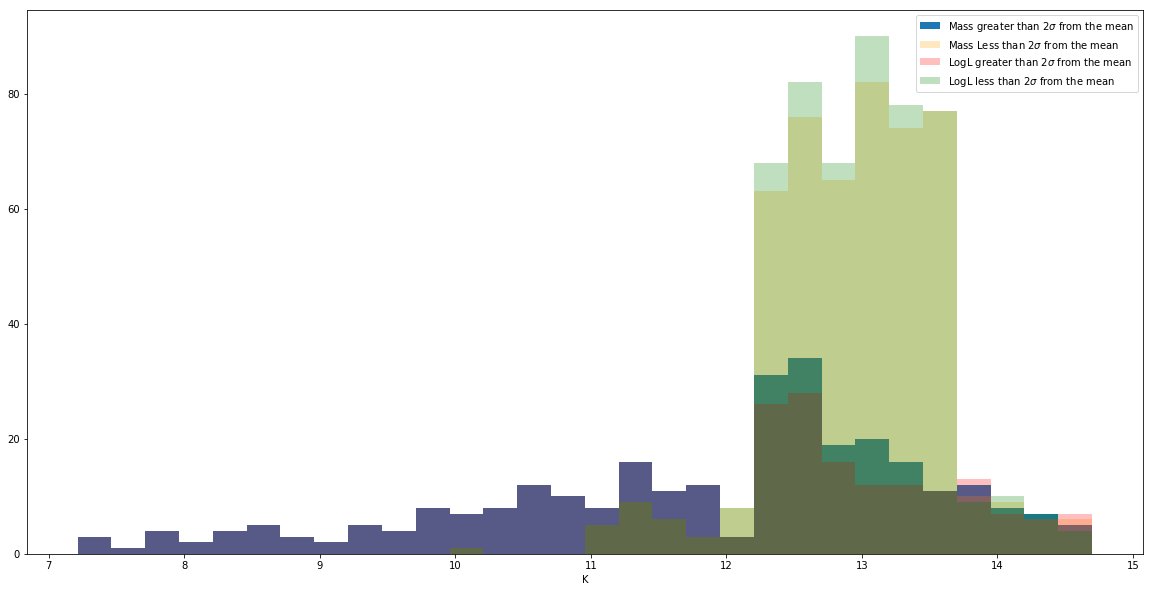

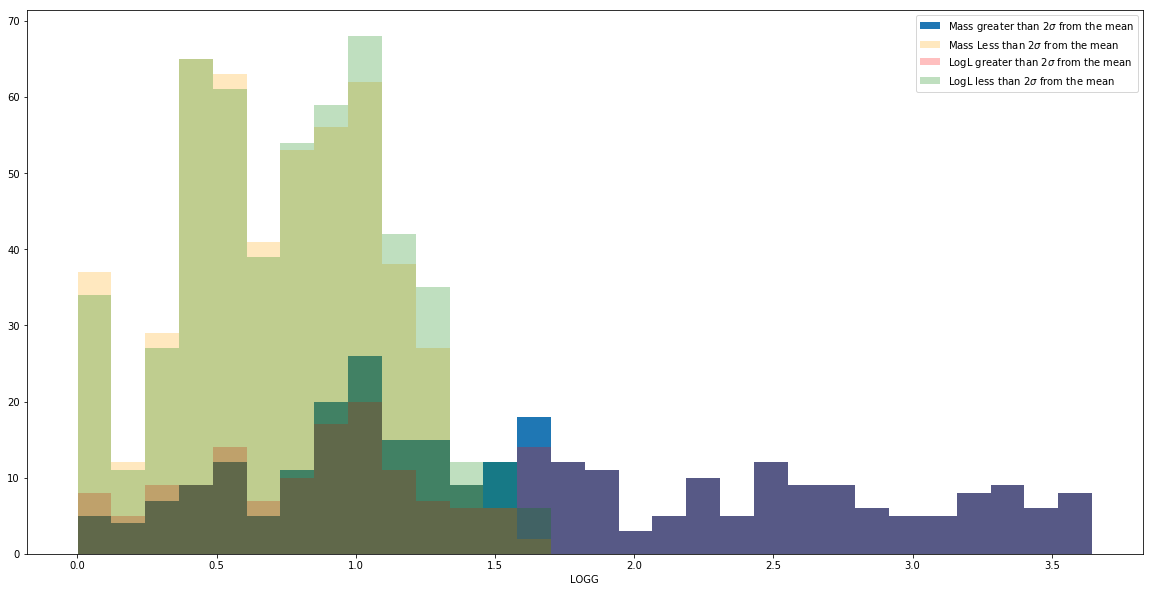

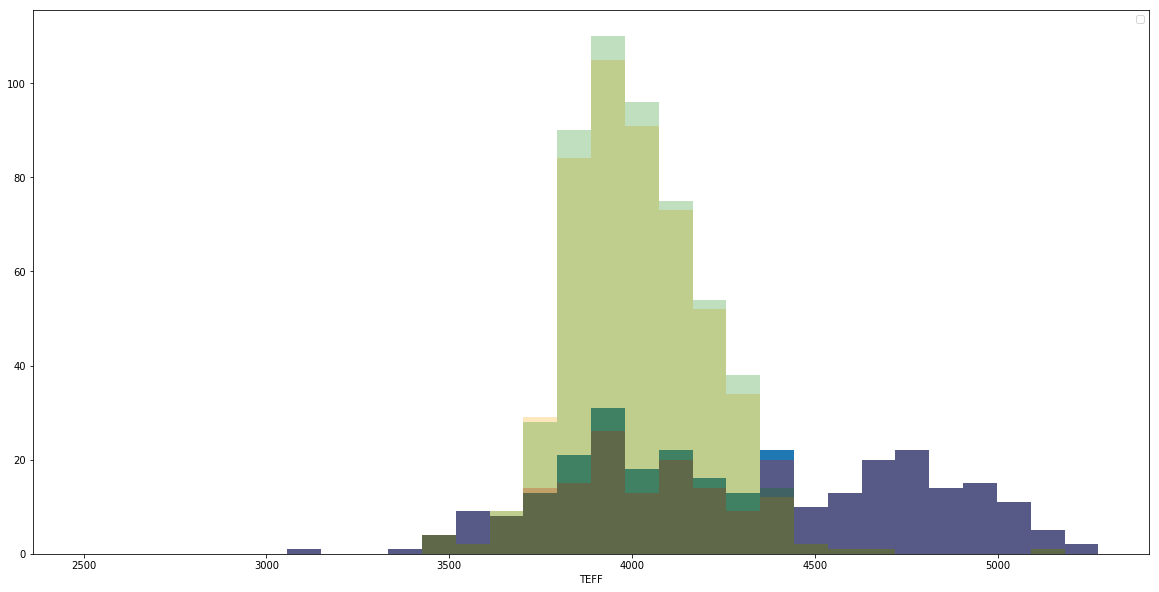

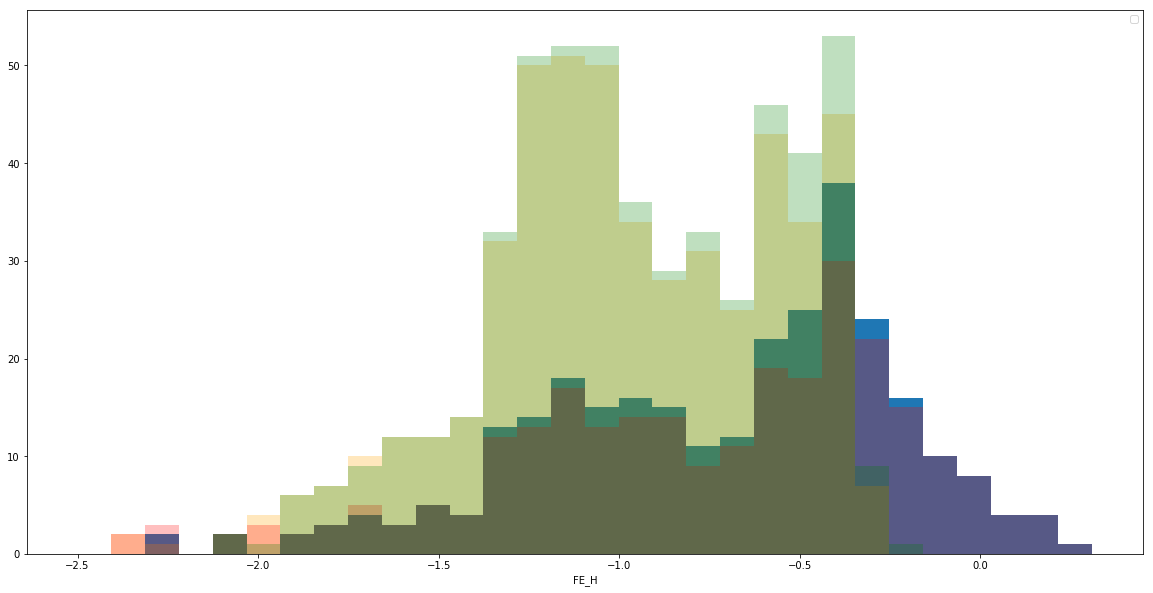

In [268]:
diffM = abs(AAS_RG['M'] - AAS_RG["ISO_MEANM"])
diffL = abs(np.log10(AAS_RG['L']) - AAS_RG["ISO_MEANL"])

bins = 30

plt.subplots(1,1, figsize = (20,10))
plt.hist(AAS_RG['BC_K_RG'][diffM > 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['BC_K_RG']),max(AAS_RG['BC_K_RG']) ),
         label= 'Mass greater than 2$\sigma$ from the mean' )
plt.hist(AAS_RG['BC_K_RG'][diffM < 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['BC_K_RG']),max(AAS_RG['BC_K_RG']) ), color = 'orange', alpha = 0.25,
         label= 'Mass Less than 2$\sigma$ from the mean')
plt.hist(AAS_RG['BC_K_RG'][diffL > 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['BC_K_RG']),max(AAS_RG['BC_K_RG']) ), color = 'red',  alpha = 0.25,
         label= 'LogL greater than 2$\sigma$ from the mean')
plt.hist(AAS_RG['BC_K_RG'][diffL < 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['BC_K_RG']),max(AAS_RG['BC_K_RG']) ), color = 'green', alpha = 0.25,
         label= 'LogL less than 2$\sigma$ from the mean')
plt.legend()
plt.xlabel('BC_K')


plt.subplots(1,1, figsize = (20,10))
plt.hist(AAS_RG['K'][diffM > 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['K']),max(AAS_RG['K']) ),
         label= 'Mass greater than 2$\sigma$ from the mean' ) 
plt.hist(AAS_RG['K'][diffM < 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['K']),max(AAS_RG['K']) ), color = 'orange', alpha = 0.25,
         label= 'Mass Less than 2$\sigma$ from the mean')
plt.hist(AAS_RG['K'][diffL > 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['K']),max(AAS_RG['K']) ), color = 'red',  alpha = 0.25,
         label= 'LogL greater than 2$\sigma$ from the mean') 
plt.hist(AAS_RG['K'][diffL < 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['K']),max(AAS_RG['K']) ), color = 'green', alpha = 0.25,
         label = 'LogL less than 2$\sigma$ from the mean')
plt.legend()
plt.xlabel('K')

plt.subplots(1,1, figsize = (20,10))
plt.hist(AAS_RG['LOGG'][diff > 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['LOGG']),max(AAS_RG['LOGG']) ),
        label= 'Mass greater than 2$\sigma$ from the mean' )
plt.hist(AAS_RG['LOGG'][diff < 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['LOGG']),max(AAS_RG['LOGG']) ), color = 'orange', alpha = 0.25,
        label= 'Mass Less than 2$\sigma$ from the mean')
plt.hist(AAS_RG['LOGG'][diffL > 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['LOGG']),max(AAS_RG['LOGG']) ), color = 'red',  alpha = 0.25,
        label= 'LogL greater than 2$\sigma$ from the mean')
plt.hist(AAS_RG['LOGG'][diffL < 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['LOGG']),max(AAS_RG['LOGG']) ), color = 'green', alpha = 0.25,
        label = 'LogL less than 2$\sigma$ from the mean')
plt.legend()
plt.xlabel('LOGG')

plt.subplots(1,1, figsize = (20,10))
plt.hist(AAS_RG['TEFF'][diff > 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['TEFF']),max(AAS_RG['TEFF']) ) )
plt.hist(AAS_RG['TEFF'][diff < 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['TEFF']),max(AAS_RG['TEFF']) ), color = 'orange', alpha = 0.26)
plt.hist(AAS_RG['TEFF'][diffL > 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['TEFF']),max(AAS_RG['TEFF']) ), color = 'red',  alpha = 0.25 )
plt.hist(AAS_RG['TEFF'][diffL < 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['TEFF']),max(AAS_RG['TEFF']) ), color = 'green', alpha = 0.25)
plt.legend()
plt.xlabel('TEFF')

plt.subplots(1,1, figsize = (20,10))
plt.hist(AAS_RG['FE_H'][diff > 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['FE_H']),max(AAS_RG['FE_H']) ) )
plt.hist(AAS_RG['FE_H'][diff < 2*AAS_RG["ISO_STDM"]],bins = bins, 
         range = (min(AAS_RG['FE_H']),max(AAS_RG['FE_H']) ), color = 'orange', alpha = 0.26)
plt.hist(AAS_RG['FE_H'][diffL > 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['FE_H']),max(AAS_RG['FE_H']) ), color = 'red',  alpha = 0.25 )
plt.hist(AAS_RG['FE_H'][diffL < 2*AAS_RG['ISO_STDL']],bins = bins, 
         range = (min(AAS_RG['FE_H']),max(AAS_RG['FE_H']) ), color = 'green', alpha = 0.25)
plt.legend()
plt.xlabel('FE_H')

### Same thing as above but for Luminocity.

/home/cody/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/cody/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/cody/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/cody/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


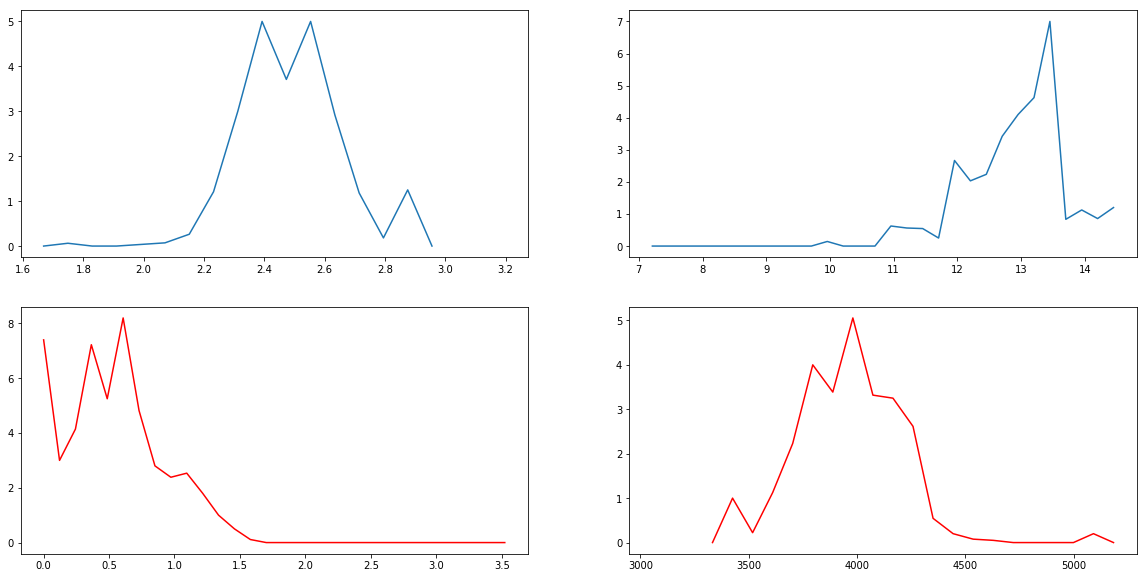

In [320]:
# Do all of the above shit but with a % within range rather than an absolute amount?
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))
bad = (np.histogram(AAS_RG['BC_K_RG'][diffM > 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['BC_K_RG']),max(AAS_RG['BC_K_RG']) )) )
good = (np.histogram(AAS_RG['BC_K_RG'][diffM < 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['BC_K_RG']),max(AAS_RG['BC_K_RG']) )))
ratio = good[0]/bad[0]
ax1.plot(good[1][0:-1],ratio)
bad = (np.histogram(AAS_RG['K'][diffM > 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['K']),max(AAS_RG['K']) )) )
good = (np.histogram(AAS_RG['K'][diffM < 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['K']),max(AAS_RG['K']) )))
ratio = good[0]/bad[0]
ax2.plot(good[1][0:-1],ratio)

bad = (np.histogram(AAS_RG['LOGG'][diffM > 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['LOGG']),max(AAS_RG['LOGG']) )) )
good = (np.histogram(AAS_RG['LOGG'][diffM < 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['LOGG']),max(AAS_RG['LOGG']) )))
ratio = good[0]/bad[0]
ax3.plot(good[1][0:-1],ratio,color = 'red')

bad = (np.histogram(AAS_RG['TEFF'][diffM > 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['TEFF']),max(AAS_RG['TEFF']) )) )
good = (np.histogram(AAS_RG['TEFF'][diffM < 2*AAS_RG['ISO_STDM']],bins = bins, 
         range = (min(AAS_RG['TEFF']),max(AAS_RG['TEFF']) )))
ratio = good[0]/bad[0]
ax4.plot(good[1][0:-1],ratio,color = 'red')

In [229]:
AAS_RG['ISO_STDL']

0.20322397351264954
nan
0.15621861815452576
0.21345974504947662
0.20171529054641724
0.18171900510787964
0.1432083398103714
0.31903180480003357
nan
0.1425655633211136
0.2104850709438324
